1. Importação de Bibliotecas e Carregamento dos Dados

Requisitos do projeto:
Para garantir que todas as dependências sejam instaladas, utilize o seguinte arquivo requirements.txt:

In [30]:
pip install -r requirements.txt


Note: you may need to restart the kernel to use updated packages.


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
import joblib

# Carregar o dataset
file_path = './teste_indicium_precificacao.csv'
data = pd.read_csv(file_path)

2. Análise Exploratória dos Dados (EDA)

                 id       host_id      latitude     longitude         price  \
count  4.889400e+04  4.889400e+04  48894.000000  48894.000000  48894.000000   
mean   1.901753e+07  6.762139e+07     40.728951    -73.952169    152.720763   
std    1.098288e+07  7.861118e+07      0.054529      0.046157    240.156625   
min    2.595000e+03  2.438000e+03     40.499790    -74.244420      0.000000   
25%    9.472371e+06  7.822737e+06     40.690100    -73.983070     69.000000   
50%    1.967743e+07  3.079553e+07     40.723075    -73.955680    106.000000   
75%    2.915225e+07  1.074344e+08     40.763117    -73.936273    175.000000   
max    3.648724e+07  2.743213e+08     40.913060    -73.712990  10000.000000   

       minimo_noites  numero_de_reviews  reviews_por_mes  \
count   48894.000000       48894.000000     38842.000000   
mean        7.030085          23.274758         1.373251   
std        20.510741          44.550991         1.680453   
min         1.000000           0.000000         

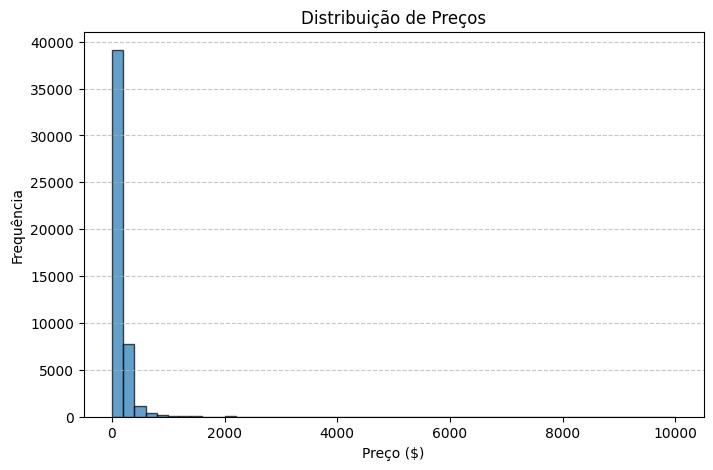

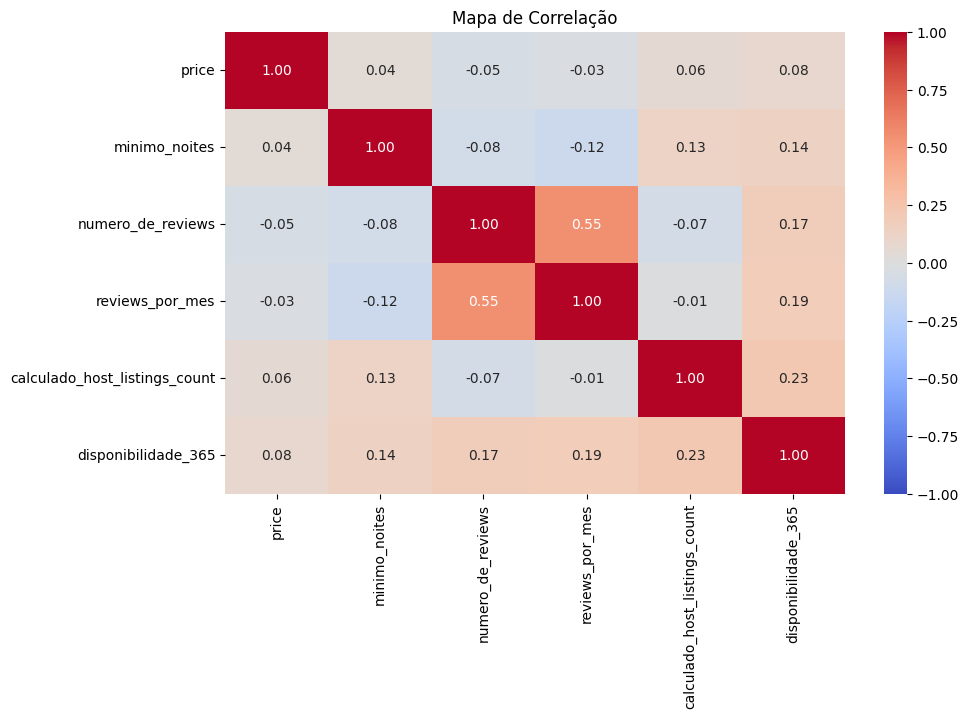

Preço médio por grupo de bairros:
 bairro_group
Bronx             87.496792
Queens            99.517649
Staten Island    114.812332
Brooklyn         124.381983
Manhattan        196.875814
Name: price, dtype: float64


In [32]:
summary_stats = data.describe()
print(summary_stats)

# Verificar valores ausentes
missing_values = data.isnull().sum()
print("Valores ausentes:\n", missing_values)

plt.figure(figsize=(8, 5))
plt.hist(data['price'], bins=50, edgecolor='k', alpha=0.7)
plt.title('Distribuição de Preços')
plt.xlabel('Preço ($)')
plt.ylabel('Frequência')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Análise de correlação
corr = data[['price', 'minimo_noites', 'numero_de_reviews', 'reviews_por_mes',
             'calculado_host_listings_count', 'disponibilidade_365']].corr()

# Heatmap de correlação
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title('Mapa de Correlação')
plt.show()

# Preço médio por grupo de bairros
avg_price_by_borough = data.groupby('bairro_group')['price'].mean().sort_values()
print("Preço médio por grupo de bairros:\n", avg_price_by_borough)

3. Preparando os Dados para Modelagem

In [38]:
# Tratar valores ausentes
num_cols = ['reviews_por_mes']
imputer = SimpleImputer(strategy='median')
data[num_cols] = imputer.fit_transform(data[num_cols])
data['nome'] = data['nome'].fillna('Desconhecido')

# Tratar variáveis 
categorical_cols = ['bairro_group', 'room_type']
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_features = pd.DataFrame(
    encoder.fit_transform(data[categorical_cols]),
    columns=encoder.get_feature_names_out(categorical_cols)
)

data_encoded = pd.concat([data, encoded_features], axis=1)
data_encoded.drop(columns=categorical_cols, inplace=True)

# Tratar outliers
data_encoded['minimo_noites'] = np.where(data_encoded['minimo_noites'] > 30, 30, data_encoded['minimo_noites'])

# Tratamento das variáveis
X = data_encoded.drop(columns=['id', 'nome', 'host_id', 'host_name', 'bairro', 'latitude',
                                'longitude', 'price', 'ultima_review'])
y = data_encoded['price']

# Divisão dos dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Remover valores ausentes restantes
X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_test.median())
y_train = y_train.dropna()
y_test = y_test.dropna()

4. Modelagem Preditiva

Regressão Linear:

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Resultados da Regressão Linear:")
print("MSE:", mse, "MAE:", mae, "R²:", r2)

Resultados da Regressão Linear:
MSE: 45015.94244968092 MAE: 70.15916664491185 R²: 0.09798663790647766


Gradient Boosting Regressor:

In [ ]:
gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
gb_model.fit(X_train, y_train)

y_pred_gb = gb_model.predict(X_test)
mse_gb = mean_squared_error(y_test, y_pred_gb)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)
print("Resultados do Gradient Boosting:")
print("MSE:", mse_gb, "MAE:", mae_gb, "R²:", r2_gb)

Resultados do Gradient Boosting:
MSE: 44438.85949865659 MAE: 65.78060812421462 R²: 0.10955001977818168


5. Previsão para o Apartamento Exemplo

In [36]:
# Dados do apartamento exemplo
example_apartment = {
    'id': 2595,
    'nome': 'Skylit Midtown Castle',
    'host_id': 2845,
    'host_name': 'Jennifer',
    'bairro_group': 'Manhattan',
    'bairro': 'Midtown',
    'latitude': 40.75362,
    'longitude': -73.98377,
    'room_type': 'Entire home/apt',
    'minimo_noites': 1,
    'numero_de_reviews': 45,
    'ultima_review': '2019-05-21',
    'reviews_por_mes': 0.38,
    'calculado_host_listings_count': 2,
    'disponibilidade_365': 355
}

# Preparar os dados do exemplo
example_df = pd.DataFrame([example_apartment])
example_df['minimo_noites'] = np.where(example_df['minimo_noites'] > 30, 30, example_df['minimo_noites'])
example_df = example_df.fillna(0)

example_encoded = pd.DataFrame(
    encoder.transform(example_df[categorical_cols]),
    columns=encoder.get_feature_names_out(categorical_cols)
)
example_df = pd.concat([example_df, example_encoded], axis=1)
example_df = example_df[X.columns]

# Fazer a previsão
predicted_price = gb_model.predict(example_df)[0]
print(f"Preço previsto para o apartamento exemplo: ${predicted_price:.2f}")

Preço previsto para o apartamento exemplo: $277.52


6. Salvando o Modelo

In [37]:
# Salvar o modelo Gradient Boosting
model_path = './gradient_boosting.pkl'
joblib.dump(gb_model, model_path)
print("Modelo salvo em:", model_path)

Modelo salvo em: ./gradient_boosting.pkl
